In [4]:
import pandas as pd
import deepchem as dc
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import os
import time
import sklearn
from sklearn.decomposition import PCA
from multiprocessing import Pool, TimeoutError, Manager
from functools import partial
from rdkit.Chem import rdmolops
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import SaltRemover
import pubchempy as pcp
import random
import json
import numpy as np
from tqdm import tqdm
from rdkit.Chem import PandasTools
from rdkit.Chem import rdmolops
from rdkit import RDConfig
import pickle 
from IPython.display import clear_output
clear_output()
# import torch

In [42]:
# https://www.rdkit.org/docs/source/rdkit.Chem.SaltRemover.html

def strip_salts_neutralize(smiles: str) -> str:

    # canonicalize original smiles to compare neutralized
    canonical_smiles=Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
    # strip salt
    remover = SaltRemover.SaltRemover()
    mol = Chem.MolFromSmiles(smiles)
    no_salt_mol = remover.StripMol(mol)
    # neutralize
    un = rdMolStandardize.Uncharger()
    uncharged_mol=un.uncharge(no_salt_mol)
    uncharged_smiles=Chem.MolToSmiles(uncharged_mol)
    updated_charge=rdmolops.GetFormalCharge(uncharged_mol)

    return canonical_smiles, uncharged_smiles, updated_charge

In [43]:
def load_predictions(target: str) -> pd.DataFrame():
    
    print("Loading Prediction Set")
    file_path=f"/home/paperspace/Desktop/DL_Project/final_outputs/{target}_predictions_flagged_admet_14Jan2024.xlsx"
    df=pd.read_excel(file_path)

    return df

In [44]:
def load_and_format_prediction_set(target: str, drugbank_only=True) -> pd.DataFrame:

    predictions_df=load_predictions(target)

    # will actually remove chembl
    if drugbank_only:
        predictions_df=predictions_df[predictions_df['source']=='Drugbank'].reset_index(drop=True)
    print(f"Number of {target} predictions: {len(predictions_df):,}")
    print(f"Breakdown of predictions:")
    # predictions_df['binary_pred'].replace({0: 'Inactive', 1: 'Active'}, inplace=True)
    # predictions_df.rename(columns={"binary_pred": "prediction"}, inplace=True)
    # display(pd.DataFrame(predictions_df['prediction'].value_counts()))

    return predictions_df

In [45]:
def load_drugbank() -> pd.DataFrame:
    """
    Load drug data from the DrugBank 3D structures SDF file and return a DataFrame.
    The DrugBank dataset contains information about drugs, including molecular structures.
    """

    print("Loading Drugbank")
    file_name="/home/paperspace/Desktop/DL_Project/data/partial_archived/drugbank_3D_structures.sdf"

    sdfFile = os.path.join(file_name)
    frame = PandasTools.LoadSDF(sdfFile,smilesName='SMILES',molColName='Molecule',
            includeFingerprints=True)

    df=frame[['DATABASE_ID', "SMILES", "INCHI_KEY", 'DRUG_GROUPS', 'MOLECULAR_WEIGHT', 'GENERIC_NAME', 'Molecule']]

    df.columns=df.columns.str.lower()
    df.rename(columns={"inchi_key": "inchikey"}, inplace=True)
    
    clear_output()
    # display(df.head(2))
    return df

### Get Chembl for Chemical Properties

In [46]:
def repull_chembl():

    print("Loading Chembl")
    chembl_df=pd.read_csv("/home/paperspace/Desktop/DL_Project/data/chembl_full_formatted.csv")

    return chembl_df

### Get PubChem for Chemical Properties Missing from Chembl

In [47]:
def load_pubchem() -> pd.DataFrame:
    
    print("Loading PubChem")
    pubchem_metadata=pd.read_csv("/home/paperspace/Desktop/DL_Project/data/prediction_set_pubchem_metadata.csv")
    pubchem_metadata=pubchem_metadata.drop_duplicates(subset='inchikey')
    pubchem_metadata.columns=[x+"_pubchem" for x in pubchem_metadata.columns]

    return pubchem_metadata

In [130]:
target="tau"

predictions_df=load_and_format_prediction_set(target=target)
drugbank=load_drugbank()
chembl_df = repull_chembl()
pubchem_metadata=load_pubchem()

# predicted_active=predictions_df[predictions_df['prediction']=='Active']
## get predictions and drugbank columns together
# joined_drugbank=predictions_df.merge(drugbank, how='left', on='inchikey')

Loading Chembl


/tmp/ipykernel_3577/1429672929.py:4: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  chembl_df=pd.read_csv("/home/paperspace/Desktop/DL_Project/data/chembl_full_formatted.csv")


Loading PubChem


In [131]:
# chembl_df = repull_chembl()

In [132]:
# joined_drugbank=drugbank.copy()
# joined_drugbank=predictions_df.merge(drugbank, how='left', on='inchikey')
# drugbank

In [133]:
# drugbank_fps=pd.read_pickle("/home/paperspace/Desktop/DL_Project/data/drugbank_fp_graphs.pickle")
# joined_drugbank=drugbank_fps.copy()
predictions_df.columns
predictions_filtered=predictions_df[['inchikey', 'uncharged_smiles', 'prediction',
'active_probability', 'database_id']]

In [134]:
joined_drugbank=predictions_filtered.merge(drugbank, how='left', on='inchikey')

### Generate the Inchikey for the Uncharged Cleaned SMILES - Join to Chembl for Properties

In [135]:
## uncharged smiles already in the dataframe
joined_drugbank['uncharged_inchikey']=joined_drugbank['uncharged_smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)))

In [136]:
equivalent=(joined_drugbank['inchikey']==joined_drugbank['uncharged_inchikey']).sum()
print(f"{equivalent:,} of {len(joined_drugbank):,} compounds do not change after removing salts and charges.")

7,487 of 8,390 compounds do not change after removing salts and charges.


In [137]:
## join chembl to drugbank
joined_chembl=joined_drugbank.merge(chembl_df, how='left', left_on='uncharged_inchikey', right_on='inchikey')
joined_chembl.drop(columns=['inchikey_y', None], errors='ignore', inplace=True)
joined_chembl.rename(columns={'inchikey_x': 'inchikey'}, inplace=True)
print(f"Length of drugbank after joining to Chembl: {len(joined_chembl):,}")
joined_chembl.head()

Length of drugbank after joining to Chembl: 8,390


,inchikey,uncharged_smiles,prediction,active_probability,database_id_x,database_id_y,smiles,drug_groups,molecular_weight,generic_name,...,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,Unnamed: 32,Unnamed: 33
0,NGVDGCNFYWLIFO-UHFFFAOYSA-N,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,Inactive,6.999738e-06,DB00114,DB00114,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,approved; investigational; nutraceutical,247.1419,Pyridoxal phosphate,...,16,7,3,0,247.0246,ACID,C8H10NO6P,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,NaN,NaN
1,DFEYYRMXOJXZRJ-UHFFFAOYSA-N,FCOC(C(F)(F)F)C(F)(F)F,Inactive,1.606359e-04,DB01236,DB01236,FCOC(C(F)(F)F)C(F)(F)F,approved; vet_approved,200.0548,Sevoflurane,...,12,1,0,0,200.0072,NEUTRAL,C4H3F7O,FCOC(C(F)(F)F)C(F)(F)F,NaN,NaN
2,RKNHJBVBFHDXGR-MRUDJCSFSA-N,[H]/N=c1\c2ncn([C@@H]3O[C@H](CO[P@](=O)(O)O[P@...,Active,2.960842e-01,DB01661,DB01661,[H]/N=c1\c2ncn([C@@H]3O[C@H](CO[P@](=O)(O)O[P@...,experimental,719.2755,1-(5-phospho-D-ribosyl)-ATP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,WHBIGIKBNXZKFE-UHFFFAOYSA-N,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...,Inactive,3.756666e-08,DB00705,DB00705,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...,approved,456.561,Delavirdine,...,32,9,3,0,456.1944,NEUTRAL,C22H28N6O3S,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...,NaN,NaN
4,MSTNYGQPCMXVAQ-KIYNQFGBSA-N,Nc1nc(=O)c2c([nH]1)NC[C@H](CNc1ccc(C(=O)N[C@@H...,Inactive,4.423987e-07,DB00116,DB00116,Nc1nc(=O)c2c([nH]1)NC[C@H](CNc1ccc(C(=O)N[C@@H...,nutraceutical,445.4292,Tetrahydrofolic acid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
pubchem_metadata.columns

Index(['generic_name_pubchem', 'Synonyms_pubchem', 'molecular_weight_pubchem',
       'Polar Surface Area_pubchem', 'CX LogP_pubchem', 'HBD_pubchem',
       'HBA_pubchem', '#Rotatable Bonds_pubchem', 'inchikey_pubchem'],
      dtype='object')

### Join To Pubchem, will fill in missing properties from Chembl

In [139]:
joined_pubchem=joined_chembl.merge(pubchem_metadata, how='left', 
                                    left_on='inchikey', right_on='inchikey_pubchem')

In [140]:
def fill_with_pubchem(df: pd.DataFrame) -> pd.DataFrame:

        ## prioritize chembl properties, if null, slide the pubchem data into the cell
    cols_to_fill=["Polar Surface Area", "molecular_weight", "CX LogP", "HBD", "HBA", "#Rotatable Bonds"]

    ## remaining missing values
    for col in cols_to_fill:
        print(f"{col} : Number of nulls: {df[col].isnull().sum():,}")

    ## iterate through columns
    for col in cols_to_fill:
        df[col]=np.where((df[col]=='None') | (df[col].isnull()),
                                    df[col+"_pubchem"],
                                    df[col]
                                    )   

    # drop columns from pubchem after using to fill in missing data
    cols_to_drop=[col for col in df.columns if "_pubchem" in col]
    print(cols_to_drop)
    df=df.drop(cols_to_drop, axis=1, errors='ignore')

     ## remaining missing values
    for col in cols_to_fill:
        print(f"{col} : Number of nulls: {df[col].isnull().sum():,}")
        
    return df

https://fluidsbarrierscns.biomedcentral.com/articles/10.1186/s12987-020-00230-3#:~:text=Molecular%20weight%20is%20another%20crucial,to%20lipid%20solubility%20%5B117%5D.

Also, a high polar surface area (PSA) greater than 80 Å2, and a tendency to form more than six hydrogen bonds are considered a limiting factor for the entry of compounds into the CNS. 

In [141]:
def format_to_floats(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Remove rows with null or 'None' values from a specified column in a DataFrame,
    and convert the column to a float data type.
    """
    df[column_name]=df[column_name].replace("None", np.nan)
    # df[column_name].replace(None, np.nan, inplace=True)
    df[column_name]=df[column_name].astype(float)

    return df

In [142]:
### Pre-filtering nominations - just save Drugbank with Molecular Properties

### Filter Nominations by Chemical Properties

Chemical properties are derived from compounds without salts or charges

In [143]:
def flag_compounds(df: pd.DataFrame) -> pd.DataFrame():

    ## polar surface area
    df=format_to_floats(df, 'Polar Surface Area')
    df['psa_flag']=np.where((df['Polar Surface Area']<=80) |(df['Polar Surface Area'].isnull()) , 0, 1) 

    ## molecular weight
    df=format_to_floats(df, "Molecular Weight")
    df['mw_flag']=np.where((df['Molecular Weight']<600)|(df['Molecular Weight'].isnull()), 0, 1)

    ## Basic pKa (verify from papers)
    df=format_to_floats(df, "CX Basic pKa")
    df['cx_basic_flag']=np.where((df['CX Basic pKa']>7) & (df['CX Basic pKa']<11), 0, 1)  
    df['cx_basic_flag']=np.where(df['CX Basic pKa'].isnull(), 0, df['cx_basic_flag'])

    ## Acidic PkA (want greater than 6)
    df=format_to_floats(df, "CX Acidic pKa")
    df['cx_acidic_flag']=np.where((df['CX Acidic pKa']>6) | (df['CX Acidic pKa'].isnull()), 0, 1)                            

    ## LogD
    df=format_to_floats(df, "CX LogD")
    df['logd_flag']=np.where((df['CX LogD']>0) & (df['CX LogD']<4), 0, 1)
    df['logd_flag']=np.where(df['logd_flag'].isnull(), 0, df['logd_flag'])

    ## LogP
    df=format_to_floats(df, "CX LogP")
    df['logp_flag']=np.where((df['CX LogP'] > 1.5) & (df['CX LogP']<5), 0, 1)
    df['logp_flag']=np.where(df['logp_flag'].isnull(), 0, df['logp_flag'])

    ## Hydrogen Bond Acceptors and Donors
    df=format_to_floats(df, "HBA")
    df=format_to_floats(df, "HBD")

    df['hbd_flag']=np.where((df['HBD'] <=6), 0, 1)
    df['hba_flag']=np.where((df['HBA'] <=6), 0, 1)

    df['hba_flag']=np.where((df['HBA'].isnull()), 0, df['hba_flag'])
    df['hbd_flag']=np.where((df['HBD'].isnull()), 0, df['hbd_flag'])

    ### Rotatable Bonds
    df=format_to_floats(df, "#Rotatable Bonds")
    df['rotation_flag']=np.where((df['#Rotatable Bonds']<5) | (df['#Rotatable Bonds'].isnull()), 0, 1)

    return df

In [144]:
joined_pubchem=fill_with_pubchem(joined_pubchem)

Polar Surface Area : Number of nulls: 2,639
molecular_weight : Number of nulls: 0
CX LogP : Number of nulls: 2,639
HBD : Number of nulls: 2,639
HBA : Number of nulls: 2,639
#Rotatable Bonds : Number of nulls: 2,639
['generic_name_pubchem', 'Synonyms_pubchem', 'molecular_weight_pubchem', 'Polar Surface Area_pubchem', 'CX LogP_pubchem', 'HBD_pubchem', 'HBA_pubchem', '#Rotatable Bonds_pubchem', 'inchikey_pubchem']
Polar Surface Area : Number of nulls: 13
molecular_weight : Number of nulls: 0
CX LogP : Number of nulls: 23
HBD : Number of nulls: 13
HBA : Number of nulls: 13
#Rotatable Bonds : Number of nulls: 13


In [145]:
joined_pubchem['CX Acidic pKa']

0        1.68
1        None
2         NaN
3        9.39
4         NaN
        ...  
8385      NaN
8386      NaN
8387      NaN
8388    11.05
8389      NaN
Name: CX Acidic pKa, Length: 8390, dtype: object

In [146]:
joined_pubchem.head()

,inchikey,uncharged_smiles,prediction,active_probability,database_id_x,database_id_y,smiles,drug_groups,molecular_weight,generic_name,...,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,Unnamed: 32,Unnamed: 33
0,NGVDGCNFYWLIFO-UHFFFAOYSA-N,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,Inactive,6.999738e-06,DB00114,DB00114,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,approved; investigational; nutraceutical,247.1419,Pyridoxal phosphate,...,16,7,3,0,247.0246,ACID,C8H10NO6P,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,NaN,NaN
1,DFEYYRMXOJXZRJ-UHFFFAOYSA-N,FCOC(C(F)(F)F)C(F)(F)F,Inactive,1.606359e-04,DB01236,DB01236,FCOC(C(F)(F)F)C(F)(F)F,approved; vet_approved,200.0548,Sevoflurane,...,12,1,0,0,200.0072,NEUTRAL,C4H3F7O,FCOC(C(F)(F)F)C(F)(F)F,NaN,NaN
2,RKNHJBVBFHDXGR-MRUDJCSFSA-N,[H]/N=c1\c2ncn([C@@H]3O[C@H](CO[P@](=O)(O)O[P@...,Active,2.960842e-01,DB01661,DB01661,[H]/N=c1\c2ncn([C@@H]3O[C@H](CO[P@](=O)(O)O[P@...,experimental,719.2755,1-(5-phospho-D-ribosyl)-ATP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,WHBIGIKBNXZKFE-UHFFFAOYSA-N,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...,Inactive,3.756666e-08,DB00705,DB00705,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...,approved,456.561,Delavirdine,...,32,9,3,0,456.1944,NEUTRAL,C22H28N6O3S,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...,NaN,NaN
4,MSTNYGQPCMXVAQ-KIYNQFGBSA-N,Nc1nc(=O)c2c([nH]1)NC[C@H](CNc1ccc(C(=O)N[C@@H...,Inactive,4.423987e-07,DB00116,DB00116,Nc1nc(=O)c2c([nH]1)NC[C@H](CNc1ccc(C(=O)N[C@@H...,nutraceutical,445.4292,Tetrahydrofolic acid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:

joined_pubchem.drop(columns=[col for col in joined_pubchem.columns if "Unna" in col],
inplace=True)

joined_pubchem.drop(columns=['Molecular Weight (Monoisotopic)', 'Smiles', 'HBA (Lipinski)',
'HBD (Lipinski)'], inplace=True, errors='ignore')

In [148]:
# joined_pubchem.to_csv("drugbank_w_molecular_properties_2023Dec26.csv", index=False)
# joined_pubchem.columns

In [149]:
# joined_pubchem=pd.read_csv("drugbank_w_molecular_properties_2023Dec26.csv")

In [150]:
joined_pubchem.columns

Index(['inchikey', 'uncharged_smiles', 'prediction', 'active_probability',
       'database_id_x', 'database_id_y', 'smiles', 'drug_groups',
       'molecular_weight', 'generic_name', 'molecule', 'uncharged_inchikey',
       'ChEMBL ID', 'Name', 'Synonyms', 'Type', 'Max Phase',
       'Molecular Weight', 'Targets', 'Bioactivities', 'AlogP',
       'Polar Surface Area', 'HBA', 'HBD', '#RO5 Violations',
       '#Rotatable Bonds', 'Passes Ro3', 'QED Weighted', 'CX Acidic pKa',
       'CX Basic pKa', 'CX LogP', 'CX LogD', 'Aromatic Rings',
       'Structure Type', 'Inorganic Flag', 'Heavy Atoms',
       '#RO5 Violations (Lipinski)', 'Molecular Species', 'Molecular Formula'],
      dtype='object')

In [151]:
preds_labeled=flag_compounds(joined_pubchem)

In [152]:
preds_labeled.columns

Index(['inchikey', 'uncharged_smiles', 'prediction', 'active_probability',
       'database_id_x', 'database_id_y', 'smiles', 'drug_groups',
       'molecular_weight', 'generic_name', 'molecule', 'uncharged_inchikey',
       'ChEMBL ID', 'Name', 'Synonyms', 'Type', 'Max Phase',
       'Molecular Weight', 'Targets', 'Bioactivities', 'AlogP',
       'Polar Surface Area', 'HBA', 'HBD', '#RO5 Violations',
       '#Rotatable Bonds', 'Passes Ro3', 'QED Weighted', 'CX Acidic pKa',
       'CX Basic pKa', 'CX LogP', 'CX LogD', 'Aromatic Rings',
       'Structure Type', 'Inorganic Flag', 'Heavy Atoms',
       '#RO5 Violations (Lipinski)', 'Molecular Species', 'Molecular Formula',
       'psa_flag', 'mw_flag', 'cx_basic_flag', 'cx_acidic_flag', 'logd_flag',
       'logp_flag', 'hbd_flag', 'hba_flag', 'rotation_flag'],
      dtype='object')

https://fluidsbarrierscns.biomedcentral.com/articles/10.1186/s12987-020-00230-3#:~:text=Molecular%20weight%20is%20another%20crucial,to%20lipid%20solubility%20%5B117%5D.

The presence of rotatable bonds in the molecule and a high affinity of binding to plasma proteins with a low off-rate can also significantly reduce CNS penetration.

In [153]:
## identify columns to mark total number of flags

relevant_cols=["generic_name", "Molecular Weight", "Polar Surface Area", "CX Acidic pKa", "CX Basic pKa", 'CX LogD','CX LogP']

In [154]:
preds_labeled.columns

Index(['inchikey', 'uncharged_smiles', 'prediction', 'active_probability',
       'database_id_x', 'database_id_y', 'smiles', 'drug_groups',
       'molecular_weight', 'generic_name', 'molecule', 'uncharged_inchikey',
       'ChEMBL ID', 'Name', 'Synonyms', 'Type', 'Max Phase',
       'Molecular Weight', 'Targets', 'Bioactivities', 'AlogP',
       'Polar Surface Area', 'HBA', 'HBD', '#RO5 Violations',
       '#Rotatable Bonds', 'Passes Ro3', 'QED Weighted', 'CX Acidic pKa',
       'CX Basic pKa', 'CX LogP', 'CX LogD', 'Aromatic Rings',
       'Structure Type', 'Inorganic Flag', 'Heavy Atoms',
       '#RO5 Violations (Lipinski)', 'Molecular Species', 'Molecular Formula',
       'psa_flag', 'mw_flag', 'cx_basic_flag', 'cx_acidic_flag', 'logd_flag',
       'logp_flag', 'hbd_flag', 'hba_flag', 'rotation_flag'],
      dtype='object')

In [155]:
preds_labeled[preds_labeled['generic_name'].fillna("N").str.contains("Mard")][["generic_name", "active_probability", "drug_groups", "cx_acidic_flag"]+relevant_cols]

,generic_name,active_probability,drug_groups,cx_acidic_flag,generic_name,Molecular Weight,Polar Surface Area,CX Acidic pKa,CX Basic pKa,CX LogD,CX LogP
5953,Mardepodect,0.000325,investigational,0,Mardepodect,392.46,52.83,NaN,4.31,4.67,4.67


In [156]:
preds_labeled['Targets'].replace("", np.nan, inplace=True)
preds_labeled=format_to_floats(preds_labeled, 'Targets')
# preds_labeled[preds_labeled['Targets'].isnull()]

### External List of CNS Drugs - Evaluate Filters

In [157]:

# https://www.cureffi.org/2013/10/04/list-of-fda-approved-drugs-and-cns-drugs-with-smiles/
drugs_data_set = pd.read_csv('/home/paperspace/Desktop/DL_Project/data/external_literature_drugs_list.txt', delimiter = "\t")

only_cns=drugs_data_set[drugs_data_set['cns_drug']==True]
only_cns=only_cns[~only_cns['smiles'].isnull()]
only_cns['canonical_smiles'], only_cns['cleaned_smiles'], only_cns['cleaned_charge'] = zip(*only_cns['smiles'].apply(lambda x: strip_salts_neutralize(x)))
only_cns=only_cns.dropna(subset='cleaned_smiles')
only_cns['uncharged_inchikey']=only_cns['cleaned_smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)))
clear_output()


In [158]:
print(f"Number of CNS drugs: {len(only_cns)}")
now_diff=(only_cns['canonical_smiles']!=only_cns['cleaned_smiles']).sum()
print(f"Number of compounds which changed after processing: {now_diff}")

Number of CNS drugs: 219
Number of compounds which changed after processing: 5


In [159]:
only_cns[only_cns['uncharged_inchikey'].duplicated()]
only_cns=only_cns.dropna(subset='uncharged_inchikey')
only_cns=only_cns[only_cns['uncharged_inchikey']!=""]

print(f"Number of distinct CNS Drugs: {len(only_cns['uncharged_inchikey'].unique()):,}")

Number of distinct CNS Drugs: 217


In [160]:
cns_chembl=only_cns.merge(chembl_df, how='inner', left_on='uncharged_inchikey', right_on='inchikey')

## maybe don't need pubchem because everything was in chembl
# cns_pubchem=cns_chembl.merge(pubchem_metadata, how='left', left_on='uncharged_inchikey', right_on='inchikey_pubchem')
# cns_pubchem.rename(columns={'Molecular Weight': 'molecular_weight'}, inplace=True, errors='ignore')

In [161]:
### Sum together number of flags
preds_labeled.drop(columns=['total_flags'], inplace=True, errors='ignore')
flag_cols=[col for col in preds_labeled.columns if "flag" in col]
preds_labeled['total_flags']=preds_labeled[flag_cols].sum(axis=1)
preds_labeled['total_flags']=preds_labeled['total_flags'].astype(int)

In [162]:
len(flag_cols)

9

In [163]:
cns_flagged=flag_compounds(cns_chembl)

In [164]:
# ### cns didn't have drug groups 
cns_flagged.drop(columns=[None], inplace=True, errors='ignore')
cns_chembl['drug_groups']="NA"
cns_flagged=flag_compounds(cns_chembl)
cns_flagged.drop(columns=[None], inplace=True, errors='ignore')
cns_flagged.drop(columns=['total_flags'], inplace=True, errors='ignore')
flag_cols=[col for col in cns_flagged.columns if "flag" in col]
cns_flagged['total_flags']=cns_flagged[flag_cols].sum(axis=1)
cns_flagged['total_flags']=cns_flagged['total_flags'].astype(int)

In [165]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

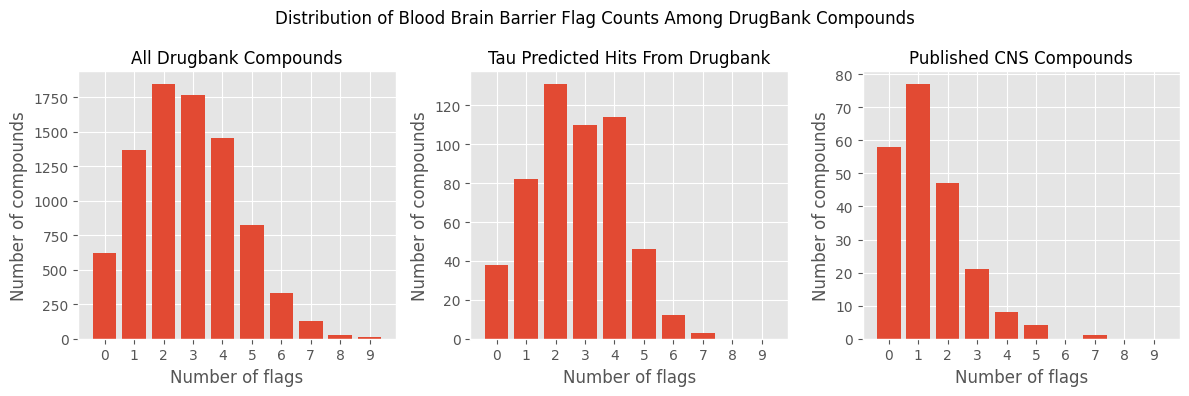

In [166]:

fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True, sharex=True)
all_comps=preds_labeled['total_flags'].value_counts().sort_index()
active_only=preds_labeled[preds_labeled['prediction']=='Active']['total_flags'].value_counts().sort_index()
cns_only=cns_flagged['total_flags'].value_counts().sort_index()

ax[0].bar(all_comps.index, all_comps)
ax[0].set_title("All Drugbank Compounds", size=12)
ax[1].bar(active_only.index, active_only)
# for title of graph
proper_caps = 'APP' if target == 'app' else 'Tau' 
ax[1].set_title(f"{proper_caps} Predicted Hits From Drugbank", size=12)
ax[2].bar(cns_only.index, cns_only)
ax[2].set_title("Published CNS Compounds", size=12)
fig.suptitle("Distribution of Blood Brain Barrier Flag Counts Among DrugBank Compounds")

for subplot in ax:
    subplot.set_xlabel("Number of flags")
    subplot.set_ylabel("Number of compounds")
    subplot.set_xticks([i for i in range(0, all_comps.index.max()+1)])

plt.show()

In [167]:
# cns_flagged.to_excel("cns_drugs_property_flags_11Feb2024.xlsx", index=False)
preds_labeled.to_excel(f"{target}_property_flags_11Feb2024.xlsx", index=False)

### Has to be 3 or less but verify first

In [168]:
cns_in_prediction_set=preds_labeled.merge(only_cns, how='inner', on='uncharged_inchikey')

print(f"Number of CNS compounds that appear in drugbank: {len(cns_in_prediction_set)}")

Number of CNS compounds that appear in drugbank: 83


In [169]:
cns_in_prediction_set['prediction'].value_counts()

Inactive    81
Active       2
Name: prediction, dtype: int64

In [170]:
predictions_admet=pd.read_excel("../final_outputs/partial_data/ADMET_Lab2_active_preds.xlsx")

In [171]:
preds_with_admet=preds_labeled.merge(predictions_admet, how='left', on='uncharged_smiles')

In [172]:
preds_labeled[preds_labeled['prediction']=='Active']

,inchikey,uncharged_smiles,prediction,active_probability,database_id_x,database_id_y,smiles,drug_groups,molecular_weight,generic_name,...,psa_flag,mw_flag,cx_basic_flag,cx_acidic_flag,logd_flag,logp_flag,hbd_flag,hba_flag,rotation_flag,total_flags
2,RKNHJBVBFHDXGR-MRUDJCSFSA-N,[H]/N=c1\c2ncn([C@@H]3O[C@H](CO[P@](=O)(O)O[P@...,Active,0.296084,DB01661,DB01661,[H]/N=c1\c2ncn([C@@H]3O[C@H](CO[P@](=O)(O)O[P@...,experimental,719.2755,1-(5-phospho-D-ribosyl)-ATP,...,1,0,0,0,1,1,1,1,1,6
39,XUWPJKDMEZSVTP-UOSCCXBLSA-N,C[C@@H]1O[C@H]2CC(=O)O[C@@H]2C2=C1C(=O)c1c(O)c...,Active,0.994655,DB01668,DB01668,C[C@@H]1O[C@H]2CC(=O)O[C@@H]2C2=C1C(=O)c1c(O)c...,experimental,300.2629,Nanaomycin D,...,1,0,0,0,1,1,0,0,0,3
41,KBPHJBAIARWVSC-RGZFRNHPSA-N,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,Active,0.954262,DB00137,DB00137,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,approved; investigational; nutraceutical,568.886,Lutein,...,0,0,0,0,1,1,0,0,1,3
42,VMWNQDUVQKEIOC-CYBMUJFWSA-N,CN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3,Active,0.999998,DB00714,DB00714,CN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3,approved; investigational,267.3224,Apomorphine,...,0,0,0,0,0,0,0,0,0,0
45,NLBDETRVUYOIHQ-UHFFFAOYSA-N,[H]/N=C(\N)c1ccc2cc(C(=O)Nc3ccc(CN)cc3)ccc2c1,Active,0.991272,DB02398,DB02398,[H]/N=C(\N)c1ccc2cc(C(=O)Nc3ccc(CN)cc3)ccc2c1,experimental,318.3724,6-[N-(4-(Aminomethyl)Phenyl)Carbamyl]-2-Naphth...,...,1,0,1,0,1,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8277,YOWNVPAUWYHLQX-UHFFFAOYSA-N,O=C(NC(=O)c1c(F)cccc1F)Nc1ccc(Cl)c(Oc2ncc(C(F)...,Active,0.919382,DB15583,DB15583,O=C(NC(=O)c1c(F)cccc1F)Nc1ccc(Cl)c(Oc2ncc(C(F)...,experimental,506.21,Fluazuron,...,1,0,1,0,1,1,0,0,0,4
8318,IHRNYHWGJUMPFJ-UHFFFAOYSA-N,COc1cc(-c2cc(=O)c3c(O)cc(O)c(CC=C(C)C)c3o2)ccc1O,Active,0.999504,DB17263,DB17263,COc1cc(-c2cc(=O)c3c(O)cc(O)c(CC=C(C)C)c3o2)ccc1O,investigational,368.385,Caflanone,...,1,0,0,0,0,0,0,0,0,1
8325,ZAWXOCUFQSQDJS-VIFPVBQESA-N,C[C@@H]1CC(=O)c2c(ccc3c2C(=O)c2cccc(O)c2C3=O)C1,Active,0.947559,DB15644,DB15644,C[C@@H]1CC(=O)c2c(ccc3c2C(=O)c2cccc(O)c2C3=O)C1,investigational,306.317,Ochromycinone,...,0,0,0,0,0,0,0,0,0,0
8327,KJXSIXMJHKAJOD-LSDHHAIUSA-N,O=C1c2c(O)cc(O)cc2O[C@H](c2cc(O)c(O)c(O)c2)[C@...,Active,0.756694,DB15645,DB15645,O=C1c2c(O)cc(O)cc2O[C@H](c2cc(O)c(O)c(O)c2)[C@...,investigational,320.251,Dihydromyricetin,...,1,0,0,0,0,0,0,1,0,2


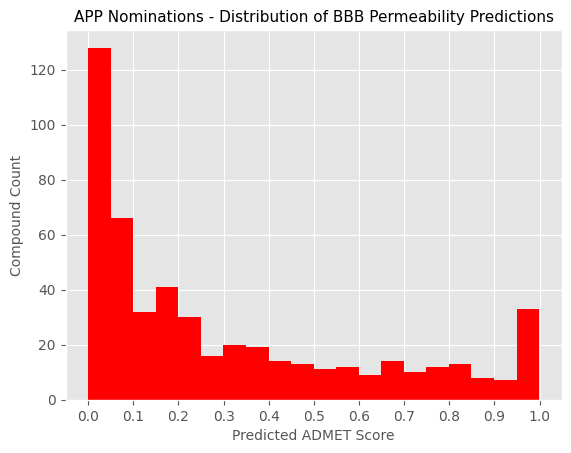

In [173]:
preds_with_admet[preds_with_admet['prediction']=='Active']['BBB'].hist(bins=20, color='red')
plt.xticks(np.arange(0, 1.1, .1))
plt.title(f"APP Nominations - Distribution of BBB Permeability Predictions", size=11)
plt.ylabel("Compound Count", size=10)
plt.xlabel("Predicted ADMET Score", size=10)
# plt.savefig("Tau_BBB_Predictions", dpi=400)
plt.show()

In [174]:
preds_with_admet.to_excel(f"{target}_predictions_flagged_admet_11Feb2024.xlsx", index=False)

In [ ]:
### CNS Drug ADMET Properties

Text(0.5, 0, 'Predicted ADMET Score')

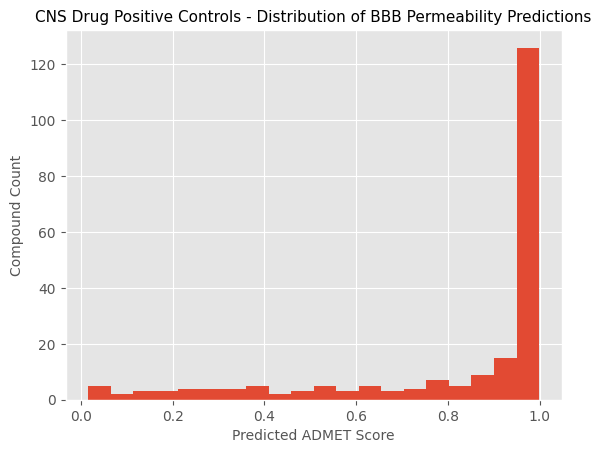

In [127]:
cns_admet=pd.read_csv("../final_outputs/partial_data/ADMET_Lab2_CNS_drugs.csv")
cns_admet['BBB'].hist(bins=20)
plt.title(f"CNS Drug Positive Controls - Distribution of BBB Permeability Predictions", size=11)
plt.ylabel("Compound Count", size=10)
plt.xlabel("Predicted ADMET Score", size=10)

In [ ]:
np.arange(0, 1.1, .1)

preds_labeled

### Determine Nominations Overlap Between Targets

In [ ]:
app_targets=pd.read_excel("/home/paperspace/Desktop/DL_Project/ipynb_files/app_detailed_nominations.xlsx")
app_preds=app_targets[['uncharged_smiles', 'prediction', 'active_probability']]
app_preds.rename(columns={'prediction': 'app_prediction',
                            'active_probability': 'app_probability'}, inplace=True)

app_metadata=app_targets.drop(columns=['prediction', 'active_probability'])

In [ ]:
tau_targets=pd.read_excel("/home/paperspace/Desktop/DL_Project/ipynb_files/tau_detailed_nominations.xlsx")

tau_preds=tau_targets[['uncharged_smiles', 'prediction', 'active_probability']]
tau_preds.rename(columns={'prediction': 'tau_prediction',
                            'active_probability': 'tau_probability'}, inplace=True)

tau_metadata=tau_targets.drop(columns=['prediction', 'active_probability'])

In [ ]:
combined_preds=tau_preds.merge(app_preds, how='inner', on='uncharged_smiles')
combined_preds['active_both']=(combined_preds['tau_prediction']=='Active') & (combined_preds['app_prediction']=='Active')

In [ ]:
combined_preds=combined_preds.drop_duplicates(subset='uncharged_smiles')
app_metadata=app_metadata.drop_duplicates(subset='uncharged_smiles')

In [ ]:
full_preds=app_metadata.merge(combined_preds, how='left', on='uncharged_smiles')
full_preds

In [ ]:
full_preds[full_preds['generic_name'].str.contains("ABX-464")]

In [ ]:
# full_preds.to_excel("app_tau_predictions_combined_active_inactive.xlsx", index=False)

In [ ]:
def filter_actives(df: pd.DataFrame, 
                    target: str, 
                    flag_threshold=3, 
                    percentile=0.9, 
                    target_threshold=999,
                    fda_filter=False) -> pd.DataFrame:

    filtered=df.copy()
    filtered=filtered[filtered[f"{target}_probability"] > percentile]
    filtered=filtered[filtered['total_flags']<=flag_threshold]
    filtered=filtered[filtered['Targets']<target_threshold]
    
    if fda_filter:
        filtered['drug_groups']=filtered['drug_groups'].str.replace("vet_approved", "vet_appro")
        filtered=filtered[(filtered['drug_groups'].str.contains("approved")) &\
                            (~filtered['drug_groups'].str.contains("withdrawn"))]

    filtered=filtered.sort_values(by=[f"{target}_probability", 'total_flags'], ascending=False)
    filtered.reset_index(drop=True, inplace=True)
    
    return filtered

### Filter Down Predictions on Different Parameters

In [ ]:
# tau_filtered=filter_actives(full_preds, 'tau', fda_filter=True)
app_filtered=filter_actives(full_preds, 'app', fda_filter=False)

In [ ]:
# tau_filtered['drug_groups'].value_counts()
app_filtered

In [ ]:
## pick 2 that are FDA approved
## two experimental or investigative

In [ ]:
## ABX-464 interesting
## Ticlatone interesting
## Triclocarban is bad - banned hormone stuff
## Anethole trithione interesting
## Clofazimine is a highly lipophilic antimicrobial riminophenazine dye used 
# in combination with other agents, such as [dapsone], for the treatment of leprosy.
# Apomorphine is an aporphine alkaloid. It has a role as an alpha-adrenergic drug, a 
# serotonergic drug, an antidyskinesia agent, a dopamine agonist, an antiparkinson drug 
# and an emetic. It derives from a hydride of an aporphine.
# Progabide is an analog and prodrug of gamma-aminobutyric acid. It is commonly used in
#  the treatment of epilepsy. It has agonistic activity for both the GABAA and GABAB receptors. 
# In clinical trials, progabide has been investigated for Parkinson's disease, schizophrenia, 
# clinical depression and anxiety disorder; its therapeutic effectiveness in these conditions
#  is not fully elucidated.

### Where do Drugs in general reside in chemical space?

### merge full preds to drugbank on database_id. Then can have all metadata but not remove the other compounds thatgot removed somewhere alongt he line.

In [ ]:
all_preds=pd.read_excel("app_tau_predictions_combined_active_inactive.xlsx")
drugbank=load_drugbank()

In [ ]:
drugbank['canonical_smiles'], drugbank['cleaned_smiles'], drugbank['cleaned_charge'] = zip(*drugbank['smiles'].apply(lambda x: strip_salts_neutralize(x)))

In [ ]:
drugbank['smiles_equal']=drugbank['canonical_smiles']==drugbank['cleaned_smiles']
display(pd.DataFrame(drugbank['smiles_equal'].value_counts()))

### Generate Morgan FPs on Drugbank Cleaned SMILES

In [ ]:
# generate morgan fingerprint 2048 length vector - multiprocessing

def generate_morgan_fp(lst, compound_data):

    # compound_data = list -> index 0 = inchi, index 1 = isomeric smile
    mol = Chem.MolFromSmiles(compound_data[1])
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits = 2048)
    compound_data.append(fp.ToBitString()) # [inchi, iso_smile, fp]
    lst.append(compound_data) # list of lists
    pbar.update(1)


fp_function_columns = drugbank[['inchikey', 'cleaned_smiles']].values.tolist()

print("First two elements of list:")
fp_function_columns[:2]

In [ ]:
# parallelize generation
if __name__ == '__main__':

    pbar = tqdm(total=len(drugbank)/8)
    dfs_list = Manager().list()
    pool = Pool(processes=8)
    res = pool.map_async(partial(generate_morgan_fp, dfs_list), fp_function_columns)
    res.wait()
    pbar.close()

In [ ]:
fp_df = pd.DataFrame(list(dfs_list), columns=['inchikey', 'cleaned_smiles', 'morgan_fp'])  # the final result

drugbank_fps=drugbank.merge(fp_df, how='left', on=['inchikey', 'cleaned_smiles'])
drugbank_fps.head(2)

In [ ]:
## 5 minutes
def generate_int_fp(lst, data):

    lst.append(list(map(int, data)))

morgan_df_vals = drugbank_fps['morgan_fp'].values.tolist()

if __name__ == '__main__':

    pbar = tqdm(total=len(drugbank)/8)
    dfs_list = Manager().list()
    pool = Pool(processes=8)
    res = pool.map_async(partial(generate_int_fp, dfs_list), morgan_df_vals)
    res.wait()
    pbar.close()
    fp_df = pd.DataFrame(list(dfs_list))

# fp_df.head()

In [ ]:

with open('pca_model_2023Ded22.pkl', 'rb') as f:
    pretrained_pca = pickle.load(f)

In [ ]:
### reduce the fps to 3 dimensions
reduced_fps=pretrained_pca.transform(fp_df)

In [ ]:
drugbank_fps['first_component_pca'] = [i[0] for i in reduced_fps]
drugbank_fps['second_component_pca'] = [i[1] for i in reduced_fps]
drugbank_fps['third_component_pca'] = [i[2] for i in reduced_fps]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
drugbank_fps['safety_concern']="No"
drugbank_fps['safety_concern']=np.where((drugbank_fps['drug_groups'].str.contains("illic")) | (drugbank_fps['drug_groups'].str.contains("withdr")),
                            "Yes",
                            "No")

In [ ]:
drugbank_fps['safety_concern'].value_counts()

In [ ]:
import seaborn as sns
sns.scatterplot(data=drugbank_fps, x='first_component_pca', y='second_component_pca', hue='safety_concern')
sns.scatterplot(data=drugbank_fps[drugbank_fps['safety_concern']=="Yes"], x='first_component_pca', y='second_component_pca')
plt.legend(title='Withdrawn or Illicit')
plt.title("Drugbank Compounds Prediction Set")
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.show()

### Check Which Drugs Are CNS Drugs, were they nominated? were they filtered by my criteria?

In [ ]:
drugbank_fps

### How Many Different Scaffolds Did Drugbank Make up? Any patterns in scaffolds it likes?